<h1 style="font-family: Georgia; font-size:3em;color:#2462C0; font-style:bold">
Character-Level Language Model</h1><br>

Have you ever wondered how Gmail automatic reply works? Or how a Neural Network can generate musical notes? The general way of generating sequence of text is to train a model to predict the next word/character given all previous words/characters. Such model is called **Statistical Language Model**. So what is a statistical language model? A statistical language model tries to capture the statistical structure (latent space) of training text it's trained on. Usually **Recurrent Neural Network (RNN)** model family is used train the model due to the fact that it's very powerful and expressive in which they remember and process past information through their high dimensional hidden state units. The main goal of any language model is to learn the joint probability distribution of sequences of characters/words in a training text, i.e. trying to learn the joint probability function. For example, if we're trying to predict a sequence of $T$ words, we try to get the joint probability $P(w_1, w_2, ..., w_T)$ as big we we can which is equal to the product of all conditional probabilities $\prod_{t = 1}^T P(w_t/w_{t-1})$ at all time steps (t). Statistical language models play a crucial part in NLP tasks such as machine translation and speech recognition.

In this notebook, we'll cover Character-level language model where almost all the concepts hold for any other language models such as word-language model. The main task of character-level language model is to predict next character given all previous characters in a sequence of data, i.e. generate text character by character. More formally, given a training sequence $(x^1, ... , x^T)$, the RNN uses the sequence of its output vectors $(o^1, ... , o^T)$ to obtain a sequence of predictive distributions $P(x^t|x<t) = softmax(o^t)$.

Let's illustrate how the character-level language model works using my first name ("imad") as an example (see figure 1 for all the details of this example).
1. We first build a vocabulary dictionary using all the unique letters of the names in the corpus as keys and the index of each letter starting from zero (since python is a zero index language) in ascending order. For our example, the vocabulary dictionary would be: {"a": 0, "d": 1, "i": 2, "m": 3}. Therefore, "imad" would become a list of the following integers: [2, 3, 0, 1].
2. Convert the input and the output characters to lists of integers using the vocabulary dictionary. In this notebook, we'll assume that $x^1 = \vec{0}$ for all examples. Therefore, $y = "imad"$ and $x = \vec{0}\ + "ima"$. In other words, $x^{t + 1} = y^t$ which gives us: $y = [2, 3, 0, 1]$ and $x = [\vec{0}, 2, 3, 0]$.
3. For each character in the input:
    1. Convert the input characters into one-hot vectors. Notice how the first character $x^1 = \vec{0}$.
    2. Compute the hidden state layer.
    3. Compute the output layer and then pass it through softmax to get the reults as probabilities.
    4. Feed the target character at time step (t) as the input character at time step $(t + 1)$.
    5. Go back to step A until we finish all the letters in the name.

The objective is to make the green numbers as big as we can and the red numbers as small as we can. The reason for that is that the true index should have the highest probability by making it as close as we can to 1. The way to do that is to measure the loss using cross-entropy and the compute the gradients of the loss w.r.t all parameters to update them in the opposite of the gradient direction. Repeating the process over many times where each time we adjust the parameters based on the gradient direction --> model will be able to correctly predict next characters given all previous one using all names in the training text. Notice that hidden state $h^4$ has all past information about all characters.

<p align="left">
<img src="posts_images/char_level_model/char_level_example.PNG"; style="width: 800px; height: 600px"><br>
<caption><center><u><font color="purple">**Figure 1:**</font></u> Illustrative example of character-level language model using RNN</center></caption>
</p>

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Training</h2>

The [dataset](http://deron.meranda.us/data/census-derived-all-first.txt) we'll be using has 5,163 names: 4,275 male names, 1,219 female names, and 331 names can be both female and male names. The RNN architecture we'll be using to train the character-level language model is called **many to many** where time steps of the input $(T_x)$ = time steps of the output $(T_y)$. In other words, the sequence of the input and output are synced (see figure 2).
<p align="left">
<img src="posts_images/char_level_model/rnn_architecture.png"; style="width: 600px; height: 600px"><br>
<caption><center><u><font color="purple">**Figure 2:**</font></u> RNN architecture</center></caption>
</p>
Thus, The character-level language model will be trained on name which means after we're done with training the model, we'll be able to generate an interesting name :).

In this section, we'll go over three main parts:
1. Forward propagation.
2. Backpropagation.
3. Sampling.

<h3 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
Forward Propagation</h3>

We'll be using Stochastic Gradient Descent (SGD) where each batch consists of only one example. In other words, the RNN model will learn from each example separately, i.e. run both forward and backward pass on each example and update parameters accordingly. Below are all the steps needed for a forward pass:
- Create vocabulary dictionary using the unique lower case letters.
    - Create character to index dictionary that maps each characters to indices in an ascending order. For example, "a" would have index 0 (since python is a zero index language) and "z" would have index 25. We will use this dictionary in converting names into lists of integers where each letter will be represented as one-hot vector.
    - Create index to character dictionary that maps indices to characters. This dictionary will be used to convert the output of the RNN model into characters which will be translated into names.
- Initialize parameters: weights will be initialized to small random numbers from standard normal distribution to break symmetry and make sure different hidden units learn different things. On the other hand, biases will be initialized to zeros.
    - $W_{hh}$: weight matrix connecting previous hidden state $h^{t - 1}$ to current hidden state $h^t$.
    - $W_{xh}$: weight matrix connecting input $x^t$ to hidden state $h^t$.
    - $b$: hidden state bias vector.
    - $W_{hy}$: weight matrix connecting hidden state $h^t$ to output $o^t$.
    - $c$: output bias vector.
- Convert input $x^t$ and the output $y^t$into one-hot vector each. The dimension of the one-hot vector is vocab_size x 1. Everything will be zero except for the index of the letter at (t) would be 1. In our case, $x^t$ would be the same as $y^t$ shifted to the right where $x^1 = \vec{0}$; however, starting from $t = 2$, $x^{t + 1} = y^{t}$. For example, if we use "imad" as the input, then $y = [2, 3, 0, 1]$ while $x = [\vec{0}, 2, 3, 0]$. Notice that $x^1 = \vec{0}$ and not the index 0. 
- Compute the hidden state using the following formula:
$$h^t = tanh(W_{hh}h^{t-1} + W_{xh}x^t + b)\tag{1}\\{}$$
Notice that we use hyperbolic tangent $(\frac{e^x - e^{-x}}{e^x + e^{-x}})$ as the non-linear function. One of the main advantages of the hyperbolic tangent function is that it resembles the identity function.
- Compute the output layer using the following formula:
$$o^t = W_{hy}h^{t} + c\tag{2}\\{}$$
- Pass the output through softmax layer to normalize the output that allows us to express it as a probability, i.e. all output will be between 0 and 1 and sum up to 1. Below is the softmax formula:
$$y^t = \frac{e^{o^t}}{\sum_ie^{o^t}}\tag{3}\\{}$$
The softmax layer has the same dimension as the output layer which is vocab_size x 1. As a result, $y^t[i]$ is the probability of of index $i$ being the next character at time step (t).
- As mentioned before, the objective of a character-level language model is to minimize the negative log-likelihood of the training sequence. Therefore, the loss function at time (t) and the total loss across all time steps are:
$$\mathcal{L}^t = -\sum_{i = 1}^{T_y}y^tlog\widehat{y^t}\tag{4}\\{}$$
$$\mathcal{L} = \sum_{t = 1}^{T_y}\mathcal{L}^t(\widehat{y^t}, y^t)\tag{5}$$
Since we'll be using SGD, the loss will be so noisy, so it's a good practice to smooth out the loss using expected weighted average.
- Pass the target character $y^t$ as the next input $x^{t + 1}$ until we finish the sequence.

<h3 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
Backpropagation</h3>

With RNN based models, the gradient-based technique that will be used is called **Backpropagation Through Time (BPTT)**. We start at last time step $T$ and backpropagate loss function w.r.t. all parameters across all time steps and sum them up (see figure 3).
<p align="left">
<img src="posts_images/char_level_model/backprop.png"; style="width: 800px; height: 400px"><br>
<caption><center><u><font color="purple">**Figure 3:**</font></u> Backpropagation Through Time (BPTT)</center></caption>
</p>
In addition, since recurrent networks are known to have steep cliffs (sudden steep decrease in $\mathcal{L}$), gradients may overshoot the minimum and undo a lot of the work that was done even if we are using adaptive learning methods such as Adam. The reason for that is that because gradient is a linear approximation of the loss function and may not capture information further than the point it was evaluated on such as the curvature of loss curve. Therefore, it's a common practice to clip the gradients to be in the interval [-maxValue, maxValue]. For this exercise, we'll clip the gradients to be in the interval [-5, 5]. That means if the gradient is > 5 or < -5, it would be clipped to 5 and -5 respectively. Below are all the formulas needed to compute the gradients w.r.t. all parameters at all time steps.

$$\nabla_{o^t}\mathcal{L} = \widehat{y^t} - y^t\tag{6}\\{}$$
$$\nabla_{W_{hy}}\mathcal{L} = \sum_t \nabla_{o^t}\mathcal{L} . {h^t}^T\tag{7}\\{}$$
$$\nabla_{c}\mathcal{L} = \sum_t \nabla_{o^t}\mathcal{L} \tag{8}\\{}$$
$$\nabla_{h^t}\mathcal{L} = W_{hy}^T . \nabla_{o^t}\mathcal{L} + \underbrace { W_{hh}^T . \nabla_{h^{t + 1}}\mathcal{L} * (1 - tanh(W_{hh}h^{t} + W_{xh}x^{t + 1} + b) ^ 2)}_{dh_{next}} \tag{9}\\{}$$
$$\nabla_{h^{t - 1}}\mathcal{L} = W_{hh}^T . \nabla_{h^t}\mathcal{L} * (1 - tanh(h^t) ^ 2)\tag{10}\\{}$$
$$\nabla_{x^t}\mathcal{L} = W_{xh}^T . \nabla_{h^t}\mathcal{L} * (1 - tanh(W_{hh}h^{t-1} + W_{xh}x^t + b) ^ 2)\tag{11}\\{}$$
$$\nabla_{W_{hh}}\mathcal{L} = \sum_t \nabla_{h^t}\mathcal{L} * (1 - tanh(W_{hh}h^{t-1} + W_{xh}x^t + b) ^ 2) . {h^{t - 1}}^T\tag{12}\\{}$$
$$\nabla_{W_{xh}}\mathcal{L} = \sum_t \nabla_{h^t}\mathcal{L} * (1 - tanh(W_{hh}h^{t-1} + W_{xh}x^t + b) ^ 2) . {x^t}^T\tag{13}\\{}$$
$$\nabla_{b}\mathcal{L} = \sum_t \nabla_{h^t}\mathcal{L} * (1 - tanh(h^t) ^ 2) \tag{14}\\{}$$

Note that at last time step $T$, we'll initialize $dh_{next}$  to zeros since we can't get values from future. To stabilize the update at each time step, we'll be using Adam (adaptive learning rate method).

<h3 style="font-family: Georgia; font-size:1.5em;color:purple; font-style:bold">
Sampling</h3><br>
Sampling is what makes the text generated by the RNN at each time step an interesting/creative text. On each time step (t), the RNN output the conditional probability distribution of the next character given all the previous characters, i.e. $P(c_t/c_1, c_2, ..., c_{t-1})$. Let's assume that at time step $t = 3$ where we're trying to predict the third character, the conditional probability distribution is: $P(c_3/c_1, c_2) = (0.2, 0.3, 0.4, 0.1)$. We'll have two extremes:
1. Maximum entropy: the character will be picked randomly using uniform probability distribution; which means that all characters in the vocabulary dictionary are equally likely. Therefore, we'll end up with maximum randomness in picking the next characters and the generated text will not be either meaningful or sound real.
2. Minimum entropy: the character with the highest conditional probability will be picked on each time step. That means next character will be what the model estimates to be the right one based on the training text and learned parameters. As a result, the name generated will be both meaningful and sound real. However, it will also be repetitive and interesting since all the parameters were optimized to learn joint probability distribution in predicting the next character.

As we increase randomness, text will loose local structure; however, as we decrease randomness, the generated text will sound more real and start to preserve its local structure. For this exercise, we will sample from the distribution that's generated by the model which can be seen as an intermediate level of randomness between maximum and minimum entropy (see figure 4). Using this sampling strategy on the above distribution, the index 0 (letter "a" in our example) has $20$% probability of being picked, while index 2 (letter "i" in our example) has $40$% probability to be picked.
<p align="left">
<img src="posts_images/char_level_model/sampling.png"; style="width: 800px; height: 400px"><br>
<caption><center><u><font color="purple">**Figure 4:**</font></u> Sampling: An example of predicting next character using character-level language model</center></caption>
</p>
Therefore, sampling will be used at test time to generate names character by character.

In [46]:
# Load packages
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

%matplotlib inline
sns.set_context("notebook")
plt.style.use("fivethirtyeight")

# Test clip_gradients function
np.random.seed(3)
dWax = np.random.randn(5,3)*10
dWaa = np.random.randn(5,5)*10
dWya = np.random.randn(2,5)*10
db = np.random.randn(5,1)*10
dby = np.random.randn(2,1)*10
gradients = {"dWax": dWax, "dWaa": dWaa, "dWya": dWya, "db": db, "dby": dby}
gradients = clip_gradients(gradients, 10)
print("gradients[\"dWaa\"][1][2] =", gradients["dWaa"][1][2])
print("gradients[\"dWax\"][3][1] =", gradients["dWax"][3][1])
print("gradients[\"dWya\"][1][2] =", gradients["dWya"][1][2])
print("gradients[\"db\"][4] =", gradients["db"][4])
print("gradients[\"dby\"][1] =", gradients["dby"][1])

# Test sample function
_, n_h = 20, 100
Wxh, Whh, Why = np.random.randn(n_h, vocab_size), np.random.randn(n_h, n_h), np.random.randn(vocab_size, n_h)
b, c = np.random.randn(n_h, 1), np.random.randn(vocab_size, 1)
parameters = {"Wxh": Wxh, "Whh": Whh, "Why": Why, "b": b, "c": c}

sample(parameters, idx_to_chars, chars_to_idx, 50)

gradients["dWaa"][1][2] = 10.0
gradients["dWax"][3][1] = -10.0
gradients["dWya"][1][2] = 0.2971381536101662
gradients["db"][4] = [10.]
gradients["dby"][1] = [8.45833407]


'ukmlryrytytkjtyktjjjvshalcukuokxmkkrrmytqrryxmnkqrz'

In [39]:
# Load names
data = open("../data/names.txt", "r").read()

# Convert characters to lower case
data = data.lower()

# Construct vocabulary using unique characters, sort it in ascending order,
# then construct two dictionaries that maps character to index and index to
# characters.
chars = list(sorted(set(data)))
chars_to_idx = {ch:i for i, ch in enumerate(chars)}
idx_to_chars = {i:ch for ch, i in chars_to_idx.items()}

# Get the size of the data and vocab size
data_size = len(data)
vocab_size = len(chars_to_idx)
print(f"There are {data_size} characters and {vocab_size} unique characters.")

There are 36121 characters and 27 unique characters.


In [55]:
def initialize_parameters(vocab_size, hidden_layer_size):
    """
    Initialze model's parameters. biases will be initialzed to zeros and
    weights will be initialized to small random numbers from standard normal
    distribution.

    Arguments
    ---------
    vocab_size : int
        size of the vocabulary dictionary.
    hidden_layer_size : int
        size of hidden units.

    Returns
    -------
    parameters : python dict
        dictionary containing all the initialized parameters.
            Whh -- hidden to hidden.
            Wxh -- input to hidden.
            b -- hidden bias.
            Why -- hidden to output.
            c -- output bias.
    """
    parameters = {}
    parameters["Whh"] = np.random.randn(
        hidden_layer_size, hidden_layer_size) * 0.01
    parameters["Wxh"] = np.random.randn(hidden_layer_size, vocab_size) * 0.01
    parameters["b"] = np.zeros((hidden_layer_size, 1))
    parameters["Why"] = np.random.randn(vocab_size, hidden_layer_size) * 0.01
    parameters["c"] = np.zeros((vocab_size, 1))

    return parameters


def initialize_adam(parameters):
    """
    Initializes v and s as two python dictionaries with:
                - keys: "Whh", "Wxh", "b", "Why", "c".
                - values: numpy arrays of zeros of the same shape as the
                          corresponding gradients/parameters.

    Arguments
    ---------
    parameters : python dict
        dictionary containing the parameters.

    Returns
    -------
    v : python dict
        dictionary that will contain the exponentially weighted average of the
        gradients.
    s : python dict
        dictionary that will contain the exponentially weighted average of the
        squared gradients.
    """
    parameters_names = ["Whh", "Wxh", "b", "Why", "c"]
    v = {}
    s = {}

    for param_name in parameters_names:
        v["d" + param_name] = np.zeros_like(parameters[param_name])
        s["d" + param_name] = np.zeros_like(parameters[param_name])

    return v, s


def softmax(z):
    """
    Implements softmax on the array z and returns normalized probability.
    
    Arguments
    ---------
    z : array-like
        array contains logits.
        
    Returns
    -------
    probs : array
        array containg the probability of each element from the logits array.
    
    """
    e_z = np.exp(z)
    probs = e_z / np.sum(e_z)
    
    return probs


def rnn_forward(x, y, h_prev, parameters):
    """
    Implement one Forward pass on one name.

    Arguments
    ---------
    x : list
        list of integers for the index of the characters in the example
        shifted one character to the right.
    y : list
        list of integers for the index of the characters in the example.
    h_prev : array
        last hidden state from the previous example.
    parameters : python dict
        dictionary containing the parameters.
    
    Returns
    -------
    loss : float
        cross-entropy loss.
    cache : tuple
        contains three python dictionaries:
            xs -- input of all time steps.
            hs -- hidden state of all time steps.
            probs -- probability distribution of each character at each time
                step.
    """
    # Retrieve parameters
    Wxh, Whh, b = parameters["Wxh"], parameters["Whh"], parameters["b"]
    Why, c = parameters["Why"], parameters["c"]

    # Initialize inputs, hidden state, output, and probabilities dictionaries
    xs, hs, os, probs = {}, {}, {}, {}

    # Initialize x0 to zero vector
    xs[0] = np.zeros((vocab_size, 1))

    # Initialize loss and assigns h_prev to last hidden state in hs
    loss = 0
    hs[-1] = np.copy(h_prev)

    # Forward pass: loop over all characters of the name
    for t in range(len(x)):
        # Convert to one-hot vector
        if t > 0:
            xs[t] = np.zeros((vocab_size, 1))
            xs[t][x[t]] = 1
        # Hidden state
        hs[t] = np.tanh(np.dot(Wxh, xs[t]) + np.dot(Whh, hs[t - 1]) + b)
        # Logits
        os[t] = np.dot(Why, hs[t]) + c
        # Probs
        probs[t] = softmax(os[t])
        # Loss
        loss -= np.log(probs[t][y[t], 0])

    cache = (xs, hs, probs)

    return loss, cache


def smooth_loss(loss, current_loss):
    """
    Compute the weighted average of the loss to smooth it out.
    """    
    return 0.999 * loss + 0.001 * current_loss


def clip_gradients(gradients, max_value):
    """
    Implements gradient clipping element-wise on gradients to be between the
    interval [-max_value, max_value].

    Arguments
    ----------
    gradients : python dict
        dictionary that stores all the gradients.
    max_value : scalar
        edge of the interval [-max_value, max_value].

    Returns
    -------
    gradients : python dict
        dictionary where all gradients were clipped.
    """
    for grad in gradients.keys():
        np.clip(gradients[grad], -max_value, max_value, out=gradients[grad])

    return gradients


def rnn_backward(y, parameters, cache):
    """
    Implements Backpropagation on one name.
    """
    # Retrieve xs, hs, and probs
    xs, hs, probs = cache

    # Initialize all gradients to zero
    dh_next = np.zeros_like(hs[0])
    
    parameters_names = ["Whh", "Wxh", "b", "Why", "c"]
    grads = {}
    for param_name in parameters_names:
        grads["d" + param_name] = np.zeros_like(parameters[param_name])

    # Iterate over all time steps in reverse order starting from Tx
    for t in reversed(range(len(xs))):
        dy = np.copy(probs[t])
        dy[y[t]] -= 1
        grads["dWhy"] += np.dot(dy, hs[t].T)
        grads["dc"] += dy
        dh = np.dot(parameters["Why"].T, dy) + dh_next
        dhraw = (1 - hs[t] ** 2) * dh
        grads["dWhh"] += np.dot(dhraw, hs[t - 1].T)
        grads["dWxh"] += np.dot(dhraw, xs[t].T)
        grads["db"] += dhraw
        dh_next = np.dot(parameters["Whh"].T, dhraw)
        # Clip the gradients using [-5, 5] as the interval
        grads = clip_gradients(grads, 5)
        
    return grads


def update_parameters_with_adam(
    parameters, grads, v, s, t, learning_rate, beta1=0.9, beta2=0.999,
    epsilon=1e-8):
    """
    Update parameters using Adam.

    Arguments
    ---------
    parameters : python dict
        dictionary containing all parameters.
    grads : python dict
        dictionary containing gradients for all parameters.
    v : python dict
        Adam variable, moving average of the first gradient.
    s : python dict
        Adam variable, moving average of the squared gradient.
    learning_rate : float
        learning rate step size.
    beta1 : float
        exponential decay hyperparameter for the first moment estimates.
    beta2 : float
        exponential decay hyperparameter for the second moment estimates.
    epsilon : float
        hyperparameter preventing division by zero in Adam updates.

    Returns
    -------
    parameters : python dict
        dictionary containing updated parameters.
    v : python dict
        Adam variable, moving average of the first gradient.
    s : python dict
        Adam variable, moving average of the squared gradient.
    """
    parameters_names = ["Whh", "Wxh", "b", "Why", "c"]
    v_corrected = {}
    s_corrected = {}

    for param_name in parameters_names:
        # Update the moving average of first gradient and squared gradient
        v["d" + param_name] = beta1 * v["d" + param_name] +\
            (1 - beta1) * grads["d" + param_name]
        s["d" + param_name] = beta2 * s["d" + param_name] +\
            (1 - beta2) * np.square(grads["d" + param_name])

        # Compute the corrected-bias estimate of the moving averages
        v_corrected["d" + param_name] = v["d" + param_name] / (1 - beta1**t)
        s_corrected["d" + param_name] = s["d" + param_name] / (1 - beta2**t)

        # update parameters
        parameters[param_name] -= (learning_rate * v_corrected["d" + param_name])\
            / (np.sqrt(s_corrected["d" + param_name] + epsilon))

    return parameters, v, s


def update_parameters(parameters, grads, learning_rate):
    for param in parameters.keys():
        parameters[param] -= learning_rate * grads["d" + param]
        
    return parameters


def sample(parameters, idx_to_chars, chars_to_idx, n):
    """
    Implements sampling of a squence of n characters characters length. The
    sampling will be based on the probability distribution output of RNN.

    Arguments
    ---------
    parameters : python dict
        dictionary storing all the parameters of the model.
    idx_to_chars : python dict
        dictionary mapping indices to characters.
    chars_to_idx : python dict
        dictionary mapping characters to indices.
    n : scalar
        number of characters to output.

    Returns
    -------
    sequence : str
        sequence of characters sampled.
    """
    # Retrienve parameters, shapes, and vocab size
    Whh, Wxh, b = parameters["Whh"], parameters["Wxh"], parameters["b"]
    Why, c = parameters["Why"], parameters["c"]
    n_h, n_x = Wxh.shape
    vocab_size = c.shape[0]

    # Initialize a0 and x1 to zero vectors
    h_prev = np.zeros((n_h, 1))
    x = np.zeros((n_x, 1))

    # Initialize empty sequence
    indices = []
    idx = -1
    counter = 0
    while (counter <= n and idx != chars_to_idx["\n"]):
        # Fwd propagation
        h = np.tanh(np.dot(Whh, h_prev) + np.dot(Wxh, x) + b)
        o = np.dot(Why, h) + c
        probs = softmax(o)

        # Sample the index of the character using generated probs distribution
        idx = np.random.choice(vocab_size, p=probs.ravel())

        # Get the character of the sampled index
        char = idx_to_chars[idx]

        # Add the char to the sequence
        indices.append(idx)

        # Update a_prev and x
        h_prev = np.copy(h)
        x = np.zeros((n_x, 1))
        x[idx] = 1

        counter += 1
    sequence = "".join([idx_to_chars[idx] for idx in indices])
    
    return sequence


def model(
    file_path, chars_to_idx, idx_to_chars, hidden_layer_size, vocab_size,
    num_epochs=10, learning_rate=0.01):
    """
    Implements RNN to generate characters.

    Arguments
    ---------
    file_path : str
        path to the file of the raw data.
    num_epochs : int
        number of passes the optimization algorithm to go over the training data.
    learning_rate : float
        step size of learning.
    chars_to_idx : python dict
        dictionary mapping characters to indices.
    idx_to_chars : python dict
        dictionary mapping indices to characters.
    hidden_layer_size : int
        number of hidden units in the hidden layer.
    vocab_size : int
        size of vocabulary dictionary.

    Returns
    -------

    """
    # Get the data
    with open(file_path) as f:
        data = f.readlines()
    examples = [x.lower().strip() for x in data]
    
    # Initialize parameters
    parameters = initialize_parameters(vocab_size, hidden_layer_size)
    
    # Initialize Adam parameters
    v, s = initialize_adam(parameters)
    t = 0

    # Initialize loss
    smoothed_loss = -np.log(1 / vocab_size) * 7
    
    # Initialize hidden state h0 and overall loss
    h_prev = np.zeros((hidden_layer_size, 1))
    overall_loss = []
    
    # Iterate over number of epochs
    for epoch in range(num_epochs):
        print(f"Epoch {epoch}---")
        # Shuffle examples
        np.random.shuffle(examples)
        
        counter = 0
        # Iterate over all examples (SGD)
        for example in examples:
            x = [None] + [chars_to_idx[char] for char in example]
            y = x[1:] + [chars_to_idx["\n"]]
            # Fwd pass
            loss, cache = rnn_forward(x, y, h_prev, parameters)
            # Compute smooth loss
            smoothed_loss = smooth_loss(smoothed_loss, loss)
            # Bwd pass
            grads = rnn_backward(y, parameters, cache)
            # Update parameters
#             t += 1
#             parameters, v, s = update_parameters_with_adam(parameters, grads, v, s, t, learning_rate)
            parameters = update_parameters(parameters, grads, learning_rate)
            # sample one name
            if counter % 10000 == 0:
                print(f"Sampled name: {sample(parameters, idx_to_chars, chars_to_idx, 10)}")
                print(f"Smoothed loss: {smoothed_loss}")
                
            counter += 1

        overall_loss.append(smoothed_loss)
        
    return parameters, overall_loss

In [56]:
parameters, loss = model("../data/names.txt", chars_to_idx, idx_to_chars, 100, vocab_size, 10, 0.01)

Epoch 0---
Sampled name: sijxqirdloq
Smoothed loss: 23.07085613044887
Epoch 1---
Sampled name: sllolest

Smoothed loss: 16.26552792397582
Epoch 2---
Sampled name: yennn

Smoothed loss: 15.50470977093098
Epoch 3---
Sampled name: cilina

Smoothed loss: 15.199752605269362
Epoch 4---
Sampled name: bera

Smoothed loss: 15.120798741571985
Epoch 5---
Sampled name: leoritune

Smoothed loss: 15.017648888614348
Epoch 6---
Sampled name: enicla

Smoothed loss: 14.833892567825243
Epoch 7---
Sampled name: brantatte

Smoothed loss: 14.824888384202032
Epoch 8---
Sampled name: marlie

Smoothed loss: 14.553926152539994
Epoch 9---
Sampled name: raghure

Smoothed loss: 14.75289620216796


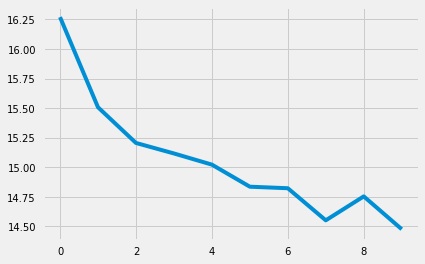

In [57]:
plt.plot(range(len(loss)), loss)

<h2 style="font-family: Georgia; font-size:2em;color:purple; font-style:bold">
Conclusion</h2><br>

- More data, bigger model, and train longer leads to interesting results. With sampling technique we're using, don't expect the RNN to generate meaningful sequence of characters (names).